In [5]:
import argparse
import pathlib
import random
from collections import deque
from typing import List, Dict, Tuple, Union
from data import Dataset, SuperclassDataset
from data_utils import *
from sampling import *
from models import BetaBernoulli
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from utils import mean_reciprocal_rank
import pickle
%matplotlib inline  

import matplotlib;matplotlib.rcParams['font.size'] = 10
import matplotlib;matplotlib.rcParams['font.family'] = 'serif'
LINEWIDTH = 13.97

LOG_FREQ = 10
method_list = ['random_data', 
               'random_data_informed', 
               'ts_informed']
DATASET_LIST = ['cifar100', 'svhn', '20newsgroup', 'dbpedia'] #'imagenet', 
output_dir = pathlib.Path("../output/confusion_matrix")

In [6]:
metric = 'confusion_matrix' # 'ece', 'confusion_matrix'
group_method = 'predicted_class'
pseudocount = 1
superclass = False #todo: superclass=true
cost_matrix = None
topk = 1

# load results and compute ground truth
ground_truth = {}
weight_k = {}
l2_error = {}
logp = {} # log likelihood of each estimated confusion matrix under dirichlet distribution

In [11]:
for dataset_name in DATASET_LIST:
    experiment_name = '%s_top%d_pseudocount%d' % (dataset_name, 1, 1)
    ground_truth[dataset_name] = pickle.load(open(output_dir / experiment_name / "ground_truth.pkl", "rb"))  
    l2_error[dataset_name] = pickle.load(open(output_dir / experiment_name / "l2_error.pkl", "rb"))  
    logp[dataset_name] = pickle.load(open(output_dir / experiment_name / "logp.pkl", "rb"))

# $L_2$

In [17]:
l2_error[dataset_name]

{'cifar100': {'random_data': array([[8.69496629e-01, 7.76317127e-01, 6.99477056e-01, ...,
          9.78631614e-05, 9.78631616e-05, 9.78631618e-05],
         [8.72564944e-01, 7.82952594e-01, 7.16014560e-01, ...,
          9.78631613e-05, 9.78631616e-05, 9.78631618e-05],
         [8.66230163e-01, 7.75034145e-01, 6.99876810e-01, ...,
          9.78631614e-05, 9.78631616e-05, 9.78631618e-05],
         ...,
         [8.72861898e-01, 7.83447581e-01, 7.06310766e-01, ...,
          9.78631613e-05, 9.78631616e-05, 9.78631618e-05],
         [8.81477132e-01, 7.81270041e-01, 6.92449583e-01, ...,
          9.78631613e-05, 9.78631616e-05, 9.78631618e-05],
         [8.85535269e-01, 8.09982001e-01, 7.28588869e-01, ...,
          9.78631614e-05, 9.78631616e-05, 9.78631618e-05]]),
  'random_data_informed': array([[2.87049885e-02, 2.68342596e-02, 2.36369505e-02, ...,
          6.97718351e-05, 6.97972218e-05, 6.98161472e-05],
         [2.91856627e-02, 2.61121007e-02, 2.50647129e-02, ...,
          6.9760

KeyError: 'random_data'

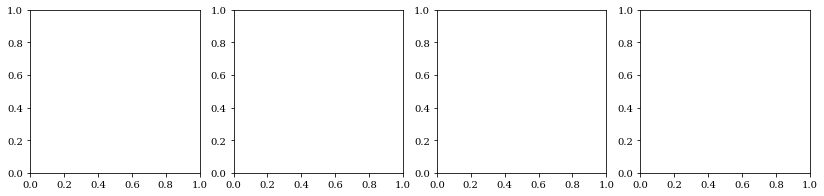

In [14]:
# plot
method_format = {#'random_arm': ('Random Arm', 'g', '.', '--'), 
                 'random_data': ('Random', 'b', '^', '--'), 
                 #'random_arm_informed': ('Random Arm Informed', 'g', '.', '-'), 
                 'random_data_informed': ('Random Informed', 'b', '^', '-'), 
                 #'ts_uniform': ('TS Symmetric', 'k', '*', '-'), 
                 'ts_informed': ('TS Informed', 'r', '+', '-'),}


fig, axes = plt.subplots(nrows=1, ncols=len(DATASET_LIST), figsize=(LINEWIDTH,3),
                        gridspec_kw = {'wspace':0.2, 'hspace':0.25})
for i, dataset_name in enumerate(DATASET_LIST):
    start = 0
    num_steps = l2_error[dataset_name]['random_data'].shape[1] - 1
    stepsize = 1
    for method_name in method_format:
        legend_name, color, marker, linestyle = method_format[method_name]    
        xrange = np.arange(num_steps) * LOG_FREQ + LOG_FREQ
        idx = np.arange(num_steps)[start:(start+num_steps)][::stepsize]   
        axes[i].plot(xrange[idx], 
                 np.mean((l2_error[dataset_name][method_name]), axis=0)[idx], 
                 label=legend_name, linewidth=3, color=color, linestyle=linestyle)
        axes[i].fill_between(xrange[idx], 
                         np.quantile(l2_error[dataset_name][method_name], 0.125, axis=0)[idx], 
                         np.quantile(l2_error[dataset_name][method_name], 0.875, axis=0)[idx], 
                         color=color, alpha=.2)
        #plt.ylim([0, 0.3])
    axes[i].set_xlabel('#Labeled')
    axes[i].set_xscale('log')
    axes[i].set_title(DATASET_NAMES[dataset_name])
    axes[i].set_xlim(0,1000)
    #axes[i].set_ylim(0,np.max(np.mean((l2_error[dataset_name]['random_data_informed']), axis=0)))
axes[0].legend(fontsize=10, loc='upper right')
axes[0].set_ylabel('$L_2$ Error')

In [ ]:
method_format = {'random_data': ('Random', 'b', '^', '--'), 
                 'random_data_informed': ('Random Informed', 'b', '^', '-'), 
                 'ts_informed': ('TS Informed', 'r', '+', '-'),}
for i, dataset_name in enumerate(DATASET_LIST):
    print('\n',dataset_name)
    dataset = Dataset.load_from_text(dataset_name)
    dataset.group(group_method = group_method)
    num_params = dataset.num_groups ^ 2
    N_list = [20,50,100]
    for N in N_list:
        N = max(int(N//10)*10, 10)
        print("N, #params=(%d,%d) =======" % (N,num_params))
        for method_name in method_format:
            print('%s: %.4f' % (method_name, l2_error[dataset_name][method_name][:, (N-LOG_FREQ)//LOG_FREQ].mean() / \
                 l2_error[dataset_name]['scores']))

In [ ]:
dataset_print= {
    'cifar100': 'CIFAR-100',
    'svhn': 'SVHN',
    '20newsgroup': '20 Newsgroups',
    'dbpedia': 'DBpedia'
}
dataset_list = ['cifar100','svhn', '20newsgroup','dbpedia']
method_format = {'random_data': ('Random', 'b', '^', '--'), 
                 'random_data_informed': ('Random Informed', 'b', '^', '-'), 
                 'ts_informed': ('TS Informed', 'r', '+', '-'),}
Nlist = [10,100,500];

print('\\begin{tabular}{@{}ccccccccccccccccc@{}}')
print('\\toprule ')
for dataset in dataset_list:
    print('& \phantom{a} &  \multicolumn{3}{c}{%s}' % dataset_print[dataset])
print('\\\ ')
for dataset in dataset_list:
    print('& \phantom{a} &  N=%d & N=%d & N=%d' % tuple(Nlist))
print('\\\ ')
print('\cmidrule{3-5} \cmidrule{7-9} \cmidrule{11-13} \cmidrule{15-17}')

for method in method_format:
    method_name = method_format[method][0]
    print('\multicolumn{2}{c}{%15s}' % method_name, end = '')
    
    for dataset_name in dataset_list:
        for N in N_list:
            val = l2_error[dataset_name][method][:, (N-LOG_FREQ)//LOG_FREQ].mean() / \
                        l2_error[dataset_name]['scores']
            print('& %4.1f  ' % (100 * val), end = '')
            
        if dataset_name != dataset_list[-1]:
            print('&', end = '')
    print('\\\\ \n', end = '');
print('\\bottomrule')
print('\\end{tabular}')

In [ ]:
dataset_print= {
    'cifar100': 'CIFAR-100',
    'svhn': 'SVHN',
    '20newsgroup': '20 Newsgroups',
    'dbpedia': 'DBpedia'
}
dataset_list = ['cifar100','svhn']
#dataset_list = ['20newsgroup','dbpedia']
method_format = {'random_data': ('Random Uninformative', 'b', '^', '--'), 
                 'random_data_informed': ('Random Informative', 'b', '^', '-'), 
                 'ts_informed': ('TS Informative', 'r', '+', '-'),}
N_list = [20, 50, 100];

print('\\begin{tabular}{@{}ccccccccc@{}}')
print('\\toprule ')
for dataset in dataset_list:
    print('& \phantom{a} &  \multicolumn{3}{c}{%s}' % dataset_print[dataset])
print('\\\ ')
print('\cmidrule{3-5} \cmidrule{7-9}')
for dataset in dataset_list:
    print('& \phantom{a} &  N=%d & N=%d & N=%d' % tuple(Nlist))
print('\\\ \\midrule')

for method in method_format:
    method_name = method_format[method][0]
    print('\multicolumn{2}{c}{%20s}' % method_name, end = '')
    
    for dataset_name in dataset_list:
        y = l2_error[dataset_name][method]/l2_error[dataset_name]['scores']
        y = np.mean(y, axis=0)        
        for N in N_list:
            val = y[(N-LOG_FREQ)//LOG_FREQ]
            print('& %.3f  ' % val, end = '')
            
        if dataset_name != dataset_list[-1]:
            print('&', end = '')
    print('\\\\ \n', end = '');
print('\\bottomrule')
print('\\end{tabular}')

In [ ]:
num_groups_dict = {}
for dataset in DATASET_LIST:
    if group_method == 'score_equal_size':
        num_groups_dict[dataset] = 10
    if group_method == 'predicted_class':
        num_groups_dict[dataset] = NUM_CLASSES_DICT[dataset]

In [ ]:
def print_narrow_table(dataset_list):
    
    N_list = [2, 5, 6, 7, 8,9, 10]
    method_format = {'random_data': ('UPrior', 'b', '^', '--'), 
                     #'ts_uniform': ('UPrior+TS', 'b', '^', '--'), 
                     'random_data_informed': ('IPrior', 'b', '^', '-'), 
                     'ts_informed': ('IPrior+TS', 'r', '+', '-'),}
    print('\\begin{tabular}{@{}ccccccc@{}}')
    print('\\toprule ')
    print('{N/K} & {N}', end = '')
    for method in method_format:
        print('& {%10s}' % method_format[method][0], end = '')
    print('\\\ ')
    
    for i, dataset_name in enumerate(dataset_list):
        print('\\midrule')
        for idx, N in enumerate(N_list):
            if idx == 0:
                name_string = DATASET_NAMES[dataset_name]
            else:
                name_string = ''
            vals = []
            for method in method_format:
                y = l2_error[dataset_name][method]/l2_error[dataset_name]['scores']
                y = np.mean(y, axis=0) 
                K = num_groups_dict[dataset_name]
                num_samples = int(N*K)
                vals.append(y[(num_samples-LOG_FREQ)//LOG_FREQ])
            print('{%20s} & %d & %d & %.3f &%.3f &\\textbf{%.3f} \\\\ \n' % \
                  (name_string, N, num_samples, vals[0], vals[1], vals[2]), end = '')
    print('\\bottomrule')
    print('\\end{tabular}')

print_narrow_table(DATASET_LIST)

In [ ]:
print(y)

In [ ]:
for method in method_format:
    method_name = method_format[method][0]
    for dataset_name in dataset_list:
        y = l2_error[dataset_name][method]/l2_error[dataset_name]['scores']
        y = np.mean(y, axis=0)        
        for N in N_list:
            val = y[(N-LOG_FREQ)//LOG_FREQ]
            print('====', method, dataset_name, (N-LOG_FREQ)//LOG_FREQ, val)
        print(y.max())

In [ ]:
# plot
method_format = {#'random_arm': ('Random Arm', 'g', '.', '--'), 
                 #'random_data': ('Random', 'b', '^', '--'), 
                 #'random_arm_informed': ('Random Arm Informed', 'g', '.', '-'), 
                 'random_data_informed': ('Random Informative', 'b', '^', '-'), 
                 #'ts_uniform': ('TS Symmetric', 'k', '*', '-'), 
                 'ts_informed': ('TS Informative', 'r', '+', '-'),}


fig, axes = plt.subplots(nrows=1, ncols=len(DATASET_LIST), figsize=(LINEWIDTH,2.2),
                        gridspec_kw = {'wspace':0.2, 'hspace':0.25})
for i, dataset_name in enumerate(DATASET_LIST):
    start = 0
    num_steps = l2_error[dataset_name]['ts_informed'].shape[1] - 1
    stepsize = 1
    for method_name in method_format:
        legend_name, color, marker, linestyle = method_format[method_name]    
        xrange = np.arange(num_steps) * LOG_FREQ + LOG_FREQ
        idx = np.arange(num_steps)[start:(start+num_steps)][::stepsize]  
        y = l2_error[dataset_name][method_name]/ l2_error[dataset_name]['scores']
        eval_mean = np.mean(y, axis=0)
        eval_upper = np.quantile(y, 0.875, axis=0)
        eval_lower = np.quantile(y, 0.125, axis=0)
        axes[i].plot(xrange[idx], 
                 eval_mean[idx], 
                 label=legend_name, linewidth=3, color=color, linestyle=linestyle)
        axes[i].fill_between(xrange[idx], 
                         eval_lower[idx], 
                         eval_upper[idx], 
                         color=color, alpha=.2)
        #plt.ylim([0, 0.3])
    axes[i].set_xlabel('#Labeled')
    axes[i].set_xscale('log')
    #axes[i].set_yscale('log')
    axes[i].set_title(DATASET_NAMES[dataset_name])
axes[0].legend(fontsize=10, loc='upper right')
axes[0].set_ylabel('$L_2$ Error')

In [ ]:
l2_error[dataset_name]['diagonal'], l2_error[dataset_name]['ones']

In [ ]:
difference.shape

In [ ]:
(difference > 0).sum(), (difference < 0).sum(), difference.max(), difference.min()

In [ ]:
from scipy.stats import wilcoxon
for i, dataset_name in enumerate(['dbpedia']):
    for n in [2,5,10]:
        for (method_0, method_1) in [#('random_data', 'random_data_informed'),\
                                     # ('random_data_informed', 'ts_informed'),\
                                    ('random_data', 'ts_informed')]:
            num_samples = n * num_groups_dict[dataset_name]
            difference = (np.array(l2_error[dataset_name][method_0][:,(num_samples-LOG_FREQ)//LOG_FREQ]) - \
                                np.array(l2_error[dataset_name][method_1][:,(num_samples-LOG_FREQ)//LOG_FREQ])) \
                                        / l2_error[dataset_name]['scores']
            w, p = wilcoxon(difference)
            print(p)
            #print(difference)
            if p > 0.0000001:
                print(dataset_name, n, method_0, method_1)